# GTHA housing market database
# OSEMN methodology Step 4: Model
# Predict land use from new features in Teranet
# Manually selected features

---

This notebook describes _Step 4: Model_ of OSEMN methodology performed on the Teranet dataset.

## Import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import os
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from time import time

sns.set()

In [2]:
import sys

sys.path.append('../../../../src')

from io_utils import df_from_csv
from plot_utils import plot_hist
from model_utils import fit_model

## Load Teranet data

In [3]:
data_path = '../../../../data/'
teranet_path = data_path + 'teranet/'
os.listdir(teranet_path)

['4_Teranet_lu_predict.csv',
 '1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 '2_Teranet_consistent.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU_LUDMTI.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

In [4]:
teranet_df = df_from_csv(teranet_path + '4_Teranet_lu_predict.csv', parse_dates=['registration_date'])

----- DataFrame loaded
in 111.46 seconds
with 5,188,513 rows
and 80 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_chang

## Load TTS data

In [5]:
tts_path = data_path + 'tts/'
os.listdir(tts_path)

['tts_num_jobs_tidy.csv',
 'TAZ_2001shp.zip',
 'TAZ_2001shp',
 'taz_tts_tidy.csv',
 'taz_info.csv',
 'TTS_variables.xlsx',
 'taz_tts.xlsx',
 'Num_of_Jobs.xlsx']

In [6]:
tts_df = df_from_csv(tts_path + 'taz_tts_tidy.csv')

----- DataFrame loaded
in 0.01 seconds
with 12,012 rows
and 8 columns
-- Column names:
 Index(['TAZ_O', 'year', 'Pop', 'FT_wrk', 'Stu', 'HH', 'Jobs', 'Cars'], dtype='object')


## Join TTS data to Teranet data

In [7]:
t = time()
df = pd.merge(teranet_df, tts_df, how='left',
              left_on=['taz_o', 'tts_year'], right_on=['TAZ_O', 'year'])
df = df.drop(['TAZ_O', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- TTS variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- TTS variables were joined to the DataFrame
in 42.78 seconds (0.71 minutes)
with 5,188,513 rows
and 86 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price

## Take a train-test subset of Teranet records

In [8]:
year_train_test = 2011
year_val1 = 2010
year_val2 = 2012

s = df.query('year == @year_train_test')
s_val1 = df.query('year == @year_val1')
s_val2 = df.query('year == @year_val2')

print("{0:,} Teranet records in the train-test subset (records from {1}).".format(len(s), year_train_test))
print("{0:,} Teranet records in the validation subset #1 (records from {1}).".format(len(s_val1), year_val1))
print("{0:,} Teranet records in the validation subset #2 (records from {1}).".format(len(s_val2), year_val2))

219,130 Teranet records in the train-test subset (records from 2011).
216,492 Teranet records in the validation subset #1 (records from 2010).
205,341 Teranet records in the validation subset #2 (records from 2012).


## Select features

In [9]:
s.columns

Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_change', 'med_price_xy', 'med_price_year',
       'price_to_med_xy', 'price_to_med_year', 'outlier_

In [10]:
all_feat_cols = ['Pop', 'FT_wrk', 'Stu', 'HH', 'Jobs', 'Cars',
                 'lucr_detached', 'lucr_duplex_townhouse', 'lucr', 'lucr_condo', 'lucr_other']
s = s[all_feat_cols]
s_val1 = s_val1[all_feat_cols]
s_val2 = s_val2[all_feat_cols]
s = s.dropna()
s_val1 = s_val1.dropna()
s_val2 = s_val2.dropna()
print("{0:,} rows in train-test subset, {1:,} rows in validation subset #1, {2:,} rows in validation subset #2"
      .format(len(s), len(s_val1), len(s_val2)))

216,348 rows in train-test subset, 215,449 rows in validation subset #1, 204,118 rows in validation subset #2


## Encode target

In [11]:
le = LabelEncoder()

s['lucr_e'] = le.fit_transform(s['lucr'])
s_val1['lucr_e'] = le.transform(s_val1['lucr'])
s_val2['lucr_e'] = le.transform(s_val2['lucr'])

s['lucr_detached_e'] = le.fit_transform(s['lucr_detached'])
s_val1['lucr_detached_e'] = le.transform(s_val1['lucr_detached'])
s_val2['lucr_detached_e'] = le.transform(s_val2['lucr_detached'])

s['lucr_duplex_townhouse_e'] = le.fit_transform(s['lucr_duplex_townhouse'])
s_val1['lucr_duplex_townhouse_e'] = le.transform(s_val1['lucr_duplex_townhouse'])
s_val2['lucr_duplex_townhouse_e'] = le.transform(s_val2['lucr_duplex_townhouse'])

s['lucr_condo_e'] = le.fit_transform(s['lucr_condo'])
s_val1['lucr_condo_e'] = le.transform(s_val1['lucr_condo'])
s_val2['lucr_condo_e'] = le.transform(s_val2['lucr_condo'])

s['lucr_other_e'] = le.fit_transform(s['lucr_other'])
s_val1['lucr_other_e'] = le.transform(s_val1['lucr_other'])
s_val2['lucr_other_e'] = le.transform(s_val2['lucr_other'])

print(s['lucr'].value_counts().sort_index())
print(s['lucr_e'].value_counts().sort_index())
print(s_val1['lucr'].value_counts().sort_index())
print(s_val1['lucr_e'].value_counts().sort_index())
print(s_val2['lucr'].value_counts().sort_index())
print(s_val2['lucr_e'].value_counts().sort_index())

s = s.drop(['lucr', 'lucr_detached', 'lucr_duplex_townhouse', 'lucr_condo', 'lucr_other'], axis=1)
s_val1 = s_val1.drop(['lucr', 'lucr_detached', 'lucr_duplex_townhouse', 'lucr_condo', 'lucr_other'], axis=1)
s_val2 = s_val2.drop(['lucr', 'lucr_detached', 'lucr_duplex_townhouse', 'lucr_condo', 'lucr_other'], axis=1)
print("Land use encoded!")
labels_list = ['condo', 'detached', 'duplex_townhouse', 'other']

condo               62693
detached            60245
duplex_townhouse    13705
other               79705
Name: lucr, dtype: int64
0    62693
1    60245
2    13705
3    79705
Name: lucr_e, dtype: int64
condo               67098
detached            62913
duplex_townhouse    14424
other               71014
Name: lucr, dtype: int64
0    67098
1    62913
2    14424
3    71014
Name: lucr_e, dtype: int64
condo               55572
detached            59491
duplex_townhouse    13243
other               75812
Name: lucr, dtype: int64
0    55572
1    59491
2    13243
3    75812
Name: lucr_e, dtype: int64
Land use encoded!


## Exploratory Data Analysis (EDA)

In [12]:
detached_corr = s.corr()['lucr_detached_e'].reset_index().rename(columns={'index': 'var', 'variable': 'class'})
duplex_townhouse_corr = \
    s.corr()['lucr_duplex_townhouse_e'].reset_index().rename(columns={'index': 'var', 'variable': 'class'})
condo_corr = s.corr()['lucr_condo_e'].reset_index().rename(columns={'index': 'var', 'variable': 'class'})
other_corr = s.corr()['lucr_other_e'].reset_index().rename(columns={'index': 'var', 'variable': 'class'})

targets_corr = pd.merge(
    pd.merge(
        pd.merge(detached_corr, duplex_townhouse_corr, on='var'), 
    condo_corr, on='var'), 
               other_corr, on='var')
mask1 = targets_corr['var'].isin(['lucr_e', 'lucr_detached_e', 'lucr_duplex_townhouse_e', 'lucr_condo_e', 'lucr_other_e'])
targets_corr = targets_corr[~mask1]
targets_corr_tidy = pd.melt(targets_corr, id_vars='var').sort_values('var')

print_top = 10
print("----- Pearson correlation coefficient between features and target classes"
      "\n\n         strongest negative correlation (top {0}):\n".format(print_top),
      targets_corr_tidy.sort_values('value').head(print_top),
      "\n\n         strongest positive correlation (top {0}):\n".format(print_top),
      targets_corr_tidy.sort_values('value', ascending=False).head(print_top))

----- Pearson correlation coefficient between features and target classes

         strongest negative correlation (top 10):
        var                 variable     value
4     Jobs          lucr_detached_e -0.278555
3       HH          lucr_detached_e -0.170032
10    Jobs  lucr_duplex_townhouse_e -0.113459
2      Stu          lucr_detached_e -0.104688
1   FT_wrk          lucr_detached_e -0.101229
0      Pop          lucr_detached_e -0.062765
23    Cars             lucr_other_e -0.061397
8      Stu  lucr_duplex_townhouse_e -0.042177
9       HH  lucr_duplex_townhouse_e -0.035917
18     Pop             lucr_other_e -0.033389 

         strongest positive correlation (top 10):
        var                 variable     value
22    Jobs             lucr_other_e  0.196563
14     Stu             lucr_condo_e  0.158197
15      HH             lucr_condo_e  0.152519
16    Jobs             lucr_condo_e  0.127144
12     Pop             lucr_condo_e  0.081645
11    Cars  lucr_duplex_townhouse_e  0.

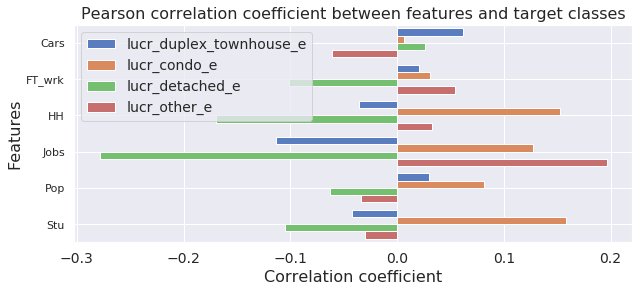

In [13]:
f, ax = plt.subplots(1, figsize=(10, 4))
sns.barplot(x="value", y="var", hue="variable", data=targets_corr_tidy,
            palette="muted", ax=ax)
ax.set_ylabel("Features", fontsize=16)
ax.set_xlabel("Correlation coefficient", fontsize=16)
ax.set_title("Pearson correlation coefficient between features and target classes", fontsize=16)
ax.grid(True)
ax.legend(loc='upper left', fontsize=14)
plt.xticks(fontsize=14)
plt.savefig("../../results/plots/tts_features_lucr_corr.png", dpi=300, bbox_inches='tight')

## Prepare features

#### Select features and target

In [14]:
target_cols = 5
s.columns[:-target_cols]

Index(['Pop', 'FT_wrk', 'Stu', 'HH', 'Jobs', 'Cars'], dtype='object')

In [15]:
X = s.iloc[:, :-target_cols].values
X_val1 = s_val1.iloc[:, :-target_cols].values
X_val2 = s_val2.iloc[:, :-target_cols].values
y = s['lucr_e'].values
y_val1 = s_val1['lucr_e'].values
y_val2 = s_val2['lucr_e'].values
print("Features and target selected.")

Features and target selected.


#### Perform train-test split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
print("Performed train-test split.")
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))
print('Labels counts in y_val1:', np.bincount(y_val1))
print('Labels counts in y_val2:', np.bincount(y_val2))

Performed train-test split.
Labels counts in y: [62693 60245 13705 79705]
Labels counts in y_train: [43885 42171  9594 55793]
Labels counts in y_test: [18808 18074  4111 23912]
Labels counts in y_val1: [67098 62913 14424 71014]
Labels counts in y_val2: [55572 59491 13243 75812]


#### Standardize features

In [17]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_val1_std = sc.transform(X_val1)
X_val2_std = sc.transform(X_val2)
print("Input features were standardized.")

Input features were standardized.


#### Normalize features

In [18]:
sc = MinMaxScaler()
sc.fit(X_train)
X_train_norm = sc.transform(X_train)
X_test_norm = sc.transform(X_test)
X_val1_norm = sc.transform(X_val1)
X_val2_norm = sc.transform(X_val2)
print("Input features were normalized.")

Input features were normalized.


### Train and test classification algorithms

#### Perceptron learning algorithm

In [19]:
model_name = 'Perceptron (raw features)'
ppn = Perceptron(max_iter=100, eta0=0.01, random_state=1)
fit_model(ppn, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)

model_name = 'Perceptron (standardized features)'
ppn = Perceptron(max_iter=100, eta0=0.01, random_state=1)
fit_model(ppn, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2)

model_name = 'Perceptron (normalized features)'
ppn = Perceptron(max_iter=100, eta0=0.01, random_state=1)
fit_model(ppn, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2)


Perceptron (raw features) fit, took 0.75 seconds (0.01 minutes)
accuracy: train=0.41, test=0.41, validation #1=0.40, validation #2=0.40

Perceptron (standardized features) fit, took 0.50 seconds (0.01 minutes)
accuracy: train=0.36, test=0.35, validation #1=0.36, validation #2=0.34

Perceptron (normalized features) fit, took 0.65 seconds (0.01 minutes)
accuracy: train=0.37, test=0.37, validation #1=0.33, validation #2=0.37


#### Logistic regression

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Logistic regression (raw features) fit, took 4.61 seconds (0.08 minutes)
accuracy: train=0.49, test=0.49, validation #1=0.50, validation #2=0.47


/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Logistic regression (standardized features) fit, took 3.07 seconds (0.05 minutes)
accuracy: train=0.49, test=0.49, validation #1=0.49, validation #2=0.45


/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Logistic regression (normalized features) fit, took 3.44 seconds (0.06 minutes)
accuracy: train=0.48, test=0.48, validation #1=0.48, validation #2=0.46


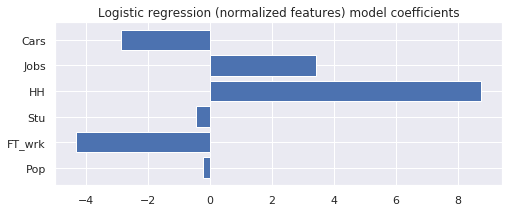

In [20]:
model_name = 'Logistic regression (raw features)'
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='auto', max_iter=50)
fit_model(lr, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)

model_name = 'Logistic regression (standardized features)'
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='auto', max_iter=50)
fit_model(lr, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2)

model_name = 'Logistic regression (normalized features)'
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='auto', max_iter=50)
lr_coef = fit_model(lr, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2,
          return_coefs=True)

# plot coefficients
plt.figure(figsize=(8, 3))
plt.barh(s.columns[:-target_cols], lr_coef)
plt.title("{0} model coefficients".format(model_name))
plt.savefig('../../results/plots/lr_tts_feats_census_norm_coefs.png', dpi=300)


Logistic regression with L1 regularization, C=1.0 (raw features) fit, took 14.43 seconds (0.24 minutes)
accuracy: train=0.50, test=0.49, validation #1=0.49, validation #2=0.45

Logistic regression with L1 regularization, C=1.0 (standardized features) fit, took 6.53 seconds (0.11 minutes)
accuracy: train=0.50, test=0.49, validation #1=0.49, validation #2=0.45

Logistic regression with L1 regularization, C=1.0 (normalized features) fit, took 14.42 seconds (0.24 minutes)
accuracy: train=0.50, test=0.49, validation #1=0.49, validation #2=0.45


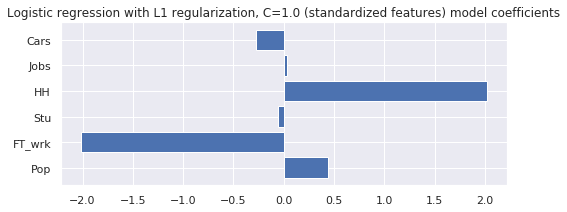

In [21]:
c = 1.0
model_name = 'Logistic regression with L1 regularization, C={0} (raw features)'.format(c)
lr = LogisticRegression(penalty='l1', C=c, random_state=1, solver='liblinear', multi_class='auto', max_iter=50)
fit_model(lr, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)

model_name = 'Logistic regression with L1 regularization, C={0} (standardized features)'.format(c)
lr = LogisticRegression(penalty='l1', C=c, random_state=1, solver='liblinear', multi_class='auto', max_iter=50)
lr_coef = fit_model(lr, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2,
                    return_coefs=True)

# plot coefficients
plt.figure(figsize=(8, 3))
plt.barh(s.columns[:-target_cols], lr_coef)
plt.title("{0} model coefficients".format(model_name))

model_name = 'Logistic regression with L1 regularization, C={0} (normalized features)'.format(c)
lr = LogisticRegression(penalty='l1', C=c, random_state=1, solver='liblinear', multi_class='auto', max_iter=50)
fit_model(lr, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2)

#### Decision Tree

In [22]:
model_name = 'Decision Tree (raw features)'
tree = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
fit_model(tree, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)

model_name = 'Decision Tree (standardized features)'
tree = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
fit_model(tree, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2)

model_name = 'Decision Tree (normalized features)'
tree = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
fit_model(tree, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2)


Decision Tree (raw features) fit, took 0.21 seconds (0.00 minutes)
accuracy: train=0.51, test=0.51, validation #1=0.47, validation #2=0.46

Decision Tree (standardized features) fit, took 0.21 seconds (0.00 minutes)
accuracy: train=0.51, test=0.51, validation #1=0.47, validation #2=0.46

Decision Tree (normalized features) fit, took 0.21 seconds (0.00 minutes)
accuracy: train=0.51, test=0.51, validation #1=0.47, validation #2=0.46


In [23]:
model_name = 'Decision Tree (raw features)'
tree = DecisionTreeClassifier(criterion='gini', max_depth=20, random_state=1)
fit_model(tree, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)


Decision Tree (raw features) fit, took 0.42 seconds (0.01 minutes)
accuracy: train=0.72, test=0.72, validation #1=0.67, validation #2=0.64


#### Random Forest

In [24]:
model_name = 'Random Forest (raw features)'
forest = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, n_jobs=8)
fit_model(forest, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)

model_name = 'Random Forest (standardized features)'
forest = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, n_jobs=8)
fit_model(forest, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2)

model_name = 'Random Forest (normalized features)'
forest = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, n_jobs=8)
fit_model(forest, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2)


Random Forest (raw features) fit, took 1.88 seconds (0.03 minutes)
accuracy: train=0.72, test=0.72, validation #1=0.67, validation #2=0.64

Random Forest (standardized features) fit, took 2.59 seconds (0.04 minutes)
accuracy: train=0.72, test=0.72, validation #1=0.67, validation #2=0.64

Random Forest (normalized features) fit, took 2.49 seconds (0.04 minutes)
accuracy: train=0.72, test=0.72, validation #1=0.67, validation #2=0.64


In [25]:
model_name = 'Random Forest (raw features)'
forest = RandomForestClassifier(criterion='gini', n_estimators=1000, random_state=1, n_jobs=8)
fit_model(forest, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)


Random Forest (raw features) fit, took 38.36 seconds (0.64 minutes)
accuracy: train=0.72, test=0.72, validation #1=0.67, validation #2=0.64


#### K-nearest neighbors

In [26]:
model_name = 'K-nearest neighbors (raw features)'
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
fit_model(knn, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)

model_name = 'K-nearest neighbors (standardized features)'
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
fit_model(knn, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2)

model_name = 'K-nearest neighbors (normalized features)'
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
fit_model(knn, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2)


K-nearest neighbors (raw features) fit, took 50.49 seconds (0.84 minutes)
accuracy: train=0.68, test=0.68, validation #1=0.63, validation #2=0.60

K-nearest neighbors (standardized features) fit, took 49.56 seconds (0.83 minutes)
accuracy: train=0.67, test=0.67, validation #1=0.61, validation #2=0.59

K-nearest neighbors (normalized features) fit, took 46.99 seconds (0.78 minutes)
accuracy: train=0.68, test=0.68, validation #1=0.64, validation #2=0.61
